In [68]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.nn import functional as F


device = 'cpu'
if torch.cuda.is_available():
	device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
	device = 'mps'
print(f"Using device {device}")

Using device mps


In [73]:
class WeatherDataset(Dataset):
	def __init__(self):
		W, H, C, B = 40, 40, 20, 1000
		data = np.loadtxt('./dataset/NimrodMLdata-1000x40x40x20-seed1.dat', comments='#', dtype=int)
		# index, H, W, t
		x = torch.from_numpy(data.ravel().reshape(B, C, H, W).transpose(0, 2, 3, 1))
		
		# Normalization
		x = x.float()
		min_val = x.amin(dim=(1, 2), keepdim=True)
		max_val = x.amax(dim=(1, 2), keepdim=True)
		x = (x - min_val) / (max_val - min_val + 1e-8)
		
		self.x = x.to(device)
		self.n_samples = B * 17

	def __getitem__(self, index):
		sequence_index = index // 17
		x =  torch.stack([self.x[sequence_index, :, :, index % 17],
										self.x[sequence_index, :, :, index % 17 + 1],
										self.x[sequence_index, :, :, index % 17 + 2]]
										)
		
		y = self.x[sequence_index, :, :, index % 17 + 3]

		return x, y
		
	def __len__(self):
		return self.n_samples

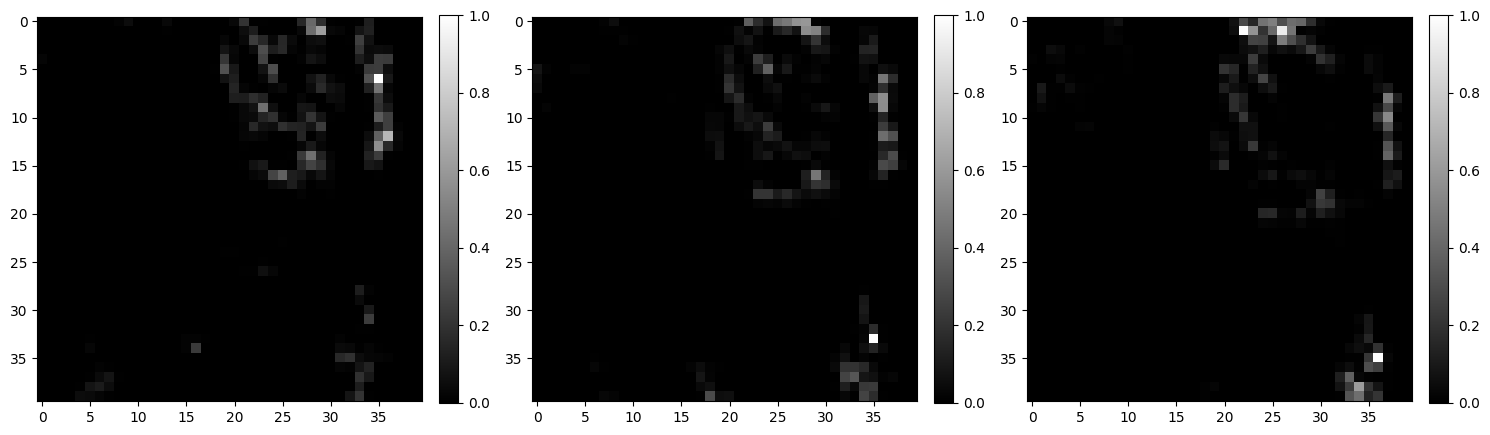

In [75]:
dataset = WeatherDataset()
x, y = dataset[0]

num_images = len(x)
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, image in enumerate(x):
	img = axes[i].imshow(image.to('cpu'), cmap='gray')
	fig.colorbar(img, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [71]:
class ConvBlock(nn.Sequential):
	def __init__(self, in_channels, out_channels):
		# The result is actually 5 x 5 convolution, but more efficient than using a 5 x 5 filter
		super().__init__(
			nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.GELU(approximate='tanh'),
			nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
			nn.BatchNorm2d(out_channels),
			nn.GELU(approximate='tanh'),
		)



class EncoderBlock(nn.Module):
	def __init__(self, in_channels, out_channels):
		super().__init__()
		self.conv = ConvBlock(in_channels, out_channels)
		self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

	def forward(self, x):
		# We return the features BEFORE pooling to use as a skip connection
		x = self.conv(x)
		p = self.pool(x)
		return x, p

class DecoderBlock(nn.Module):
	def __init__(self, in_channels, skip_channels, out_channels):
		super().__init__()
		self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
		self.conv = ConvBlock(out_channels + skip_channels, out_channels)

	def forward(self, x, skip):
		x = self.upsample(x)
		x = torch.cat([x, skip], dim=1)
		return self.conv(x)
		


class TransformersUNet(nn.Module):
	def __init__(self):
		super().__init__()
		# --- ENCODER (The Downward Path) ---
		self.enc1 = EncoderBlock(1, 8)
		self.enc2 = EncoderBlock(8, 16)
		self.enc3 = EncoderBlock(16, 32)

		# --- BOTTLENECK ---
		self.bottleneck = ConvBlock(32, 64)
		
		# --- DECODER (The Upward Path) ---
		self.dec3 = DecoderBlock(64, 32, 32)
		self.dec2 = DecoderBlock(32, 16, 16)
		self.dec1 = DecoderBlock(16, 8, 8)
		
		self.final_conv = nn.Conv2d(8, 1, kernel_size=1)
		self.relu = nn.ReLU()

	def forward(self, x):
		# Encoder: xn are features for skips, pn are pooled for next layer
		x1, p1 = self.enc1(x)
		x2, p2 = self.enc2(p1) 
		x3, p3 = self.enc3(p2)
		
		# Bottleneck
		b = self.bottleneck(p3)
		
		# Decoder + Skip Connections
		d3 = self.dec3(b, x3)
		d2 = self.dec2(d3, x2)
		d1 = self.dec1(d2, x1)
		f = self.final_conv(d1)
		return self.relu(f)
	

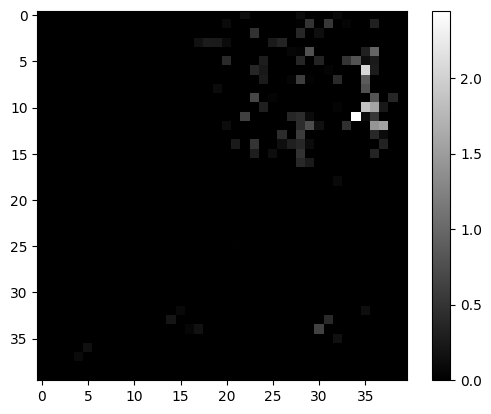

In [72]:
model = TransformersUNet()
model.to(device)

y = model.forward(dataset_sample[0].float().unsqueeze(0).unsqueeze(0))


plt.imshow(y.detach().cpu().squeeze().numpy(), cmap='gray')
plt.colorbar()
plt.show()